In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
sys.path.append('../..')
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import xgboost as xgb
from utils.general import calc_efficiency
from utils.feature_importance import get_pfi_obs
from utils.feature_ranking import confident_simultaneous_ranking
from utils.plot_ranking import plot_ranks
from experiments.real_data.preprocess_data import get_data_by_name
%matplotlib inline
sns.set_theme(style='whitegrid')

In [10]:
# Set all fonts' sizes
params = {'legend.fontsize': 32,
          'legend.title_fontsize': 32,
          'axes.labelsize': 36,
          'axes.titlesize':40,
          'xtick.labelsize':32,
          'ytick.labelsize':32, 
          'lines.linewidth': 4, 
          'figure.titlesize': 40}
pylab.rcParams.update(params)

# Avoid Type 3 fonts
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [11]:
name = 'compas'
filepath = 'data/compas-scores-two-years.csv'
out_path = r'../../figures/real_data/compas/'

data, target_name = get_data_by_name(name, filepath)

In [12]:
data.head()

,Sex,Age,Priors_Count,C_Charge_Degree,Two_Year_Recid,Length_Of_Stay,Score,Race
0,1,69,0,0,0,0,1,0
1,1,34,0,0,1,10,1,1
2,1,24,4,0,1,1,1,1
3,1,44,0,1,0,1,1,0
4,1,41,14,0,1,6,1,0


In [13]:
data.shape

(6172, 8)

In [14]:
feature_names = data.columns.drop(target_name)
# Split data
train, test = train_test_split(data, test_size=0.1, random_state=2)

X_train = train.drop(target_name, axis=1).reset_index(drop=True)
X_test = test.drop(target_name, axis=1).reset_index(drop=True)

Y_train = train[target_name].values
Y_test = test[target_name].values

print('train:', X_train.shape)
print('test:', X_test.shape)

train: (5554, 7)
test: (618, 7)


In [15]:
model = xgb.XGBRFClassifier(random_state=2023, use_label_encoder=False,
                          objective='binary:logistic', eval_metric='logloss')
model.fit(X_train, Y_train)

print(model.score(X_train, Y_train))
print(model.score(X_test, Y_test))

0.8660424918977314
0.8462783171521036


In [16]:
train_scores = []
test_scores = []
all_pfi_means = []
rep = 100
n = 3000
model = xgb.XGBRFClassifier(random_state=2023, use_label_encoder=False,
                          objective='binary:logistic', eval_metric='logloss')

for i in range(rep):
    data_i = train.sample(frac=1, replace=True, random_state=i+1)
    train_i = data_i.sample(n=n, replace=False, random_state=i+2)
    X_train = train_i.drop(target_name, axis=1).reset_index(drop=True)
    Y_train = train_i[target_name].values
    model.fit(X_train, Y_train)
    train_scores.append(model.score(X_train, Y_train))
    test_scores.append(model.score(X_test, Y_test))
    pfi_means, _ = get_pfi_obs(model, X_test, Y_test, num_perms=1000, is_reg=False, seed=2023, return_local=False)
    all_pfi_means.append(pfi_means)

In [17]:
scores = pd.DataFrame({'train_score': train_scores, 'test_score': test_scores})
scores.head()

,train_score,test_score
0,0.877667,0.839806
1,0.877667,0.846278
2,0.880333,0.849515
3,0.878333,0.844660
4,0.880667,0.849515


In [18]:
all_pfi_means = pd.DataFrame(all_pfi_means, columns=feature_names)
all_pfi_means.head()

,Sex,Age,Priors_Count,C_Charge_Degree,Two_Year_Recid,Length_Of_Stay,Race
0,0.000299,0.022811,0.032065,0.000176,0.002782,0.006012,0.000545
1,0.000069,0.025417,0.029821,0.000324,0.001906,0.006139,0.000945
2,0.000291,0.023817,0.029476,0.000136,0.003281,0.007067,0.000318
3,0.000058,0.024719,0.035281,-0.000207,0.002581,0.005994,0.000923
4,0.000111,0.024737,0.030290,0.000146,0.003109,0.008045,0.000358


In [19]:
all_pfi_means = all_pfi_means.values

In [20]:
colors = sns.color_palette("Set2")
colors_map = {feature: colors[i] for i, feature in enumerate(feature_names)}

10 efficiency: 0.1428571428571428
40 efficiency: 0.0


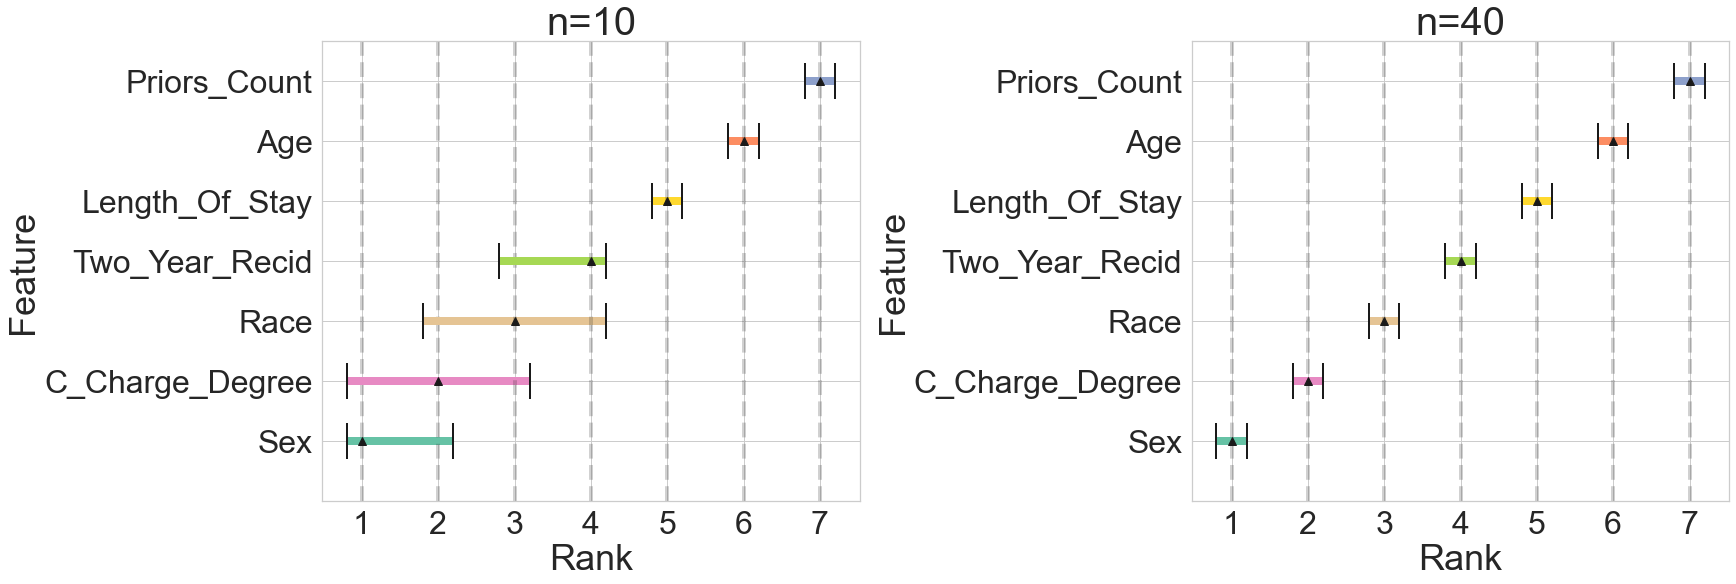

In [21]:
p = all_pfi_means.shape[1]
ns = [10, 40]
fig, axs = plt.subplots(1, len(ns), constrained_layout=True, figsize=(12 * len(ns), 8))
prev_n = 0
for i, n in enumerate(ns):
    base = all_pfi_means[prev_n:n + prev_n, :]
    ranks = confident_simultaneous_ranking(base, 0.1, 'min_p', rep_bootstrap=1000)
    print(n, 'efficiency:', calc_efficiency(ranks['U'], ranks['L']))
    pfi_means = np.mean(base, axis=0)
    plot_ranks(ranks, pfi_means, feature_names, ax=axs[i], colors_map=colors_map)
    axs[i].set_title('n=' + str(n))
    prev_n = n